In [2]:
import numpy as np
import pandas as pd

In [89]:
from subprocess import check_call
from collections import Counter
import networkx as nx
#from snakes.nets import PetriNet
#from pntools.petrinet import PetriNet
from petri_net import PetriNet
import pylab as plt

In [171]:
from networkx.drawing.nx_pydot import graphviz_layout
from pyvis.network import Network

In [2]:
df = pd.read_csv("InternationalDeclarations.csv")

In [3]:
df.head()

,id,org:resource,concept:name,time:timestamp,org:role,case:Permit travel permit number,case:DeclarationNumber,case:Amount,case:RequestedAmount,case:Permit TaskNumber,...,case:concept:name,case:Permit OrganizationalEntity,case:travel permit number,case:Permit RequestedBudget,case:id,case:Permit ID,case:Permit id,case:BudgetNumber,case:Permit ActivityNumber,case:AdjustedAmount
0,rv_travel permit 76455_6,STAFF MEMBER,Start trip,2016-10-05 00:00:00+02:00,EMPLOYEE,travel permit number 76456,declaration number 76458,39.664561,39.664561,UNKNOWN,...,declaration 76457,organizational unit 65458,travel permit number 76456,41.613445,declaration 76457,travel permit 76455,travel permit 76455,budget 144133,activity 46005,39.664561
1,rv_travel permit 76455_7,STAFF MEMBER,End trip,2016-10-05 00:00:00+02:00,EMPLOYEE,travel permit number 76456,declaration number 76458,39.664561,39.664561,UNKNOWN,...,declaration 76457,organizational unit 65458,travel permit number 76456,41.613445,declaration 76457,travel permit 76455,travel permit 76455,budget 144133,activity 46005,39.664561
2,st_step 76459_0,STAFF MEMBER,Permit SUBMITTED by EMPLOYEE,2017-04-06 13:32:10+02:00,EMPLOYEE,travel permit number 76456,declaration number 76458,39.664561,39.664561,UNKNOWN,...,declaration 76457,organizational unit 65458,travel permit number 76456,41.613445,declaration 76457,travel permit 76455,travel permit 76455,budget 144133,activity 46005,39.664561
3,st_step 76460_0,STAFF MEMBER,Permit FINAL_APPROVED by SUPERVISOR,2017-04-06 13:32:28+02:00,SUPERVISOR,travel permit number 76456,declaration number 76458,39.664561,39.664561,UNKNOWN,...,declaration 76457,organizational unit 65458,travel permit number 76456,41.613445,declaration 76457,travel permit 76455,travel permit 76455,budget 144133,activity 46005,39.664561
4,st_step 76461_0,STAFF MEMBER,Declaration SUBMITTED by EMPLOYEE,2017-04-07 13:38:14+02:00,EMPLOYEE,travel permit number 76456,declaration number 76458,39.664561,39.664561,UNKNOWN,...,declaration 76457,organizational unit 65458,travel permit number 76456,41.613445,declaration 76457,travel permit 76455,travel permit 76455,budget 144133,activity 46005,39.664561


In [4]:
procs = df[['case:id', 'concept:name', 'time:timestamp']]

In [5]:
procs.shape

(72151, 3)

In [6]:
ids = procs['case:id'].unique()

In [7]:
ids[0]

'declaration 76457'

In [8]:
processes = []
for idx in ids:
    process = tuple(procs[procs['case:id'] == idx].sort_values('time:timestamp')['concept:name'].values)
    processes.append(process)

In [9]:
counts = Counter(processes)

In [206]:
class HeuristicMiner():
    # Получение всех узлов
    def all_events(self, log):
        tl = set()
        for item in log:
            for i in item:
                tl.add(i)
        return tl
    
    # Получение начальной вершины
    def get_start_nodes(self, log):
        tl = set()
        for item in log:
            tl.add(item[0])
        return tl
    
    # получение последней вершины
    def get_end_nodes(self, log):
        ends = set()
        for item in log:
            ends.add(item[-1])
        return ends
    
    # Получение ребра в противоположном направлении
#     def reverse_of(self, pair):
#         return (pair[1], pair[0])
    
    # Словари индекс->символ и символ->индекс
    def get_char_to_int_dict(self, events):
        return {e:i for e, i in zip(events, range(len(events)))},{i:e for e, i in zip(events, range(len(events)))}
    
#     def isPairInMatrix(self, pair, idx):
#         if self.footprint_matrix[idx[pair[0]]][idx[pair[1]]] == -1:
#             return True
#         else:
#             return False
    
    # инициализация footprint матрицы
    def get_footprint_matrix(self, log):
        idx = self.idx[0]
#         pairs = set()
#         for item in log:
#             for j in range(len(item)-1):
#                 pair = (item[j], item[j+1])
#                 if pair[0] == pair[1]:
#                     self.footprint_matrix[idx[pair[0]]][idx[pair[1]]] = 1
#                 elif self.reverse_of(pair) in pairs:
#                     self.footprint_matrix[idx[pair[0]]][idx[pair[1]]] = 2
#                     self.footprint_matrix[idx[pair[1]]][idx[pair[0]]] = 2
#                 else:
#                     self.footprint_matrix[idx[pair[0]]][idx[pair[1]]] = 1
#                     self.footprint_matrix[idx[pair[1]]][idx[pair[0]]] = -1
#                 pairs.add(pair)

        pairs = {}
        for left in idx.keys():
            for right in idx.keys():
                pairs[(left, right)] = 0
                
        for item, count in log.items():
            for j in range(len(item)-1):
                pair = (item[j], item[j+1])
                pairs[pair] += count
                    
        for left in idx.keys():
            for right in idx.keys():
                if left == right:
                    self.footprint_matrix[idx[left]][idx[right]] = pairs[(left, right)] / (1 + pairs[(left, right)])
                else:
                    self.footprint_matrix[idx[left]][idx[right]] \
                    = (pairs[(left, right)] - pairs[right, left]) / (pairs[(left, right)] + pairs[right, left] + 1)
        self.pairs = pairs        
        return self.footprint_matrix
    
    # Получение пар с казуальной связью
    def get_caus_pairs(self, matrix, events, threshold):
        idx = self.idx[1]
        caus_pairs = set()
        n = len(events)
        for i in range(n):
            for j in range(n):
                if matrix[i][j] >= threshold:
                    caus_pairs.add(((idx[i],), (idx[j],)))
        return dict.fromkeys(caus_pairs, 0)
    
    # слияние двух множеств
    def merge(self, pairs):
        merged = tuple()
        for pair in pairs:
            for item in pair:
                if item not in merged:
                    merged += item,
        return merged
    
    # проверка условия альфа майнера
    def check_conditions(self, matrix, lefts, rights, condition):
        idx = self.idx[0]
        for i, j in zip(lefts, rights):
            for k, m in zip(i, j):
                if not condition(matrix[idx[k]][idx[m]]):
                    return False
        return True
    
    # слияние множеств, если условия альфа майнера выполнено
    def merge_tuples_with_conditions(self, p1, p2, matrix, threshold):
        merged = tuple()
        for i, j in zip(p1, p2):
            merged += (self.merge((i, j))),

        lefts, rights = np.meshgrid(merged[0], merged[1])
        cond1 = self.check_conditions(matrix, lefts, rights, lambda x: x >= threshold)

        if not cond1:
            return None

        lefts, rights = np.meshgrid(merged[0], merged[0])
        cond2 = self.check_conditions(matrix, lefts, rights, lambda x: x < threshold)

        if not cond2:
            return None

        lefts, rights = np.meshgrid(merged[1], merged[1])
        cond3 = self.check_conditions(matrix, lefts, rights, lambda x: x < threshold)

        if not cond3:
            return None

        return merged
    
    # Выполнение алгоритма, пока датасет изменяется
    def get_dataset(self, caus, matrix, threshold):
        isModified = True
        while isModified:
            caus_list = list(caus.keys())
            isModified = False
            new_caus = set()
            for i in range(len(caus)):
                for j in range(i+1, len(caus)):
                    merged = self.merge_tuples_with_conditions(caus_list[i], caus_list[j], matrix, threshold)
                    if merged is not None:
                        caus[caus_list[i]] += 1
                        caus[caus_list[j]] += 1
                        new_caus.add(merged)
                        isModified = True

            for key, val in caus.items():
                if val == 0:
                    new_caus.add(key)

            caus = dict.fromkeys(new_caus, 0)

        return new_caus
    
    def __call__(self, counts, threshold):
        events = self.all_events(list(counts.keys()))
        self.idx = self.get_char_to_int_dict(events)
        self.footprint_matrix = [[0]*len(events) for i in range(len(events))]
        start_nodes = self.get_start_nodes(list(counts.keys()))
        end_nodes = self.get_end_nodes(list(counts.keys()))
        self.get_footprint_matrix(counts)
        caus = self.get_caus_pairs(self.footprint_matrix, events, threshold)
        return events, start_nodes, end_nodes, self.get_dataset(caus, self.footprint_matrix, threshold)

In [207]:
heuristic_miner = HeuristicMiner()

In [208]:
log = list(counts.keys())

In [234]:
#expected output: set of tuples of tules of str's
events, start_nodes, end_nodes, dataset = heuristic_miner(counts, 0.9)

In [235]:
g = nx.DiGraph()

In [236]:
g.add_nodes_from(events)

In [237]:
for fromnodes, tonodes in dataset:
    for fromnode in fromnodes:
        for tonode in tonodes:
            g.add_edge(fromnode, tonode)

In [238]:
pos = graphviz_layout(g, 'dot')

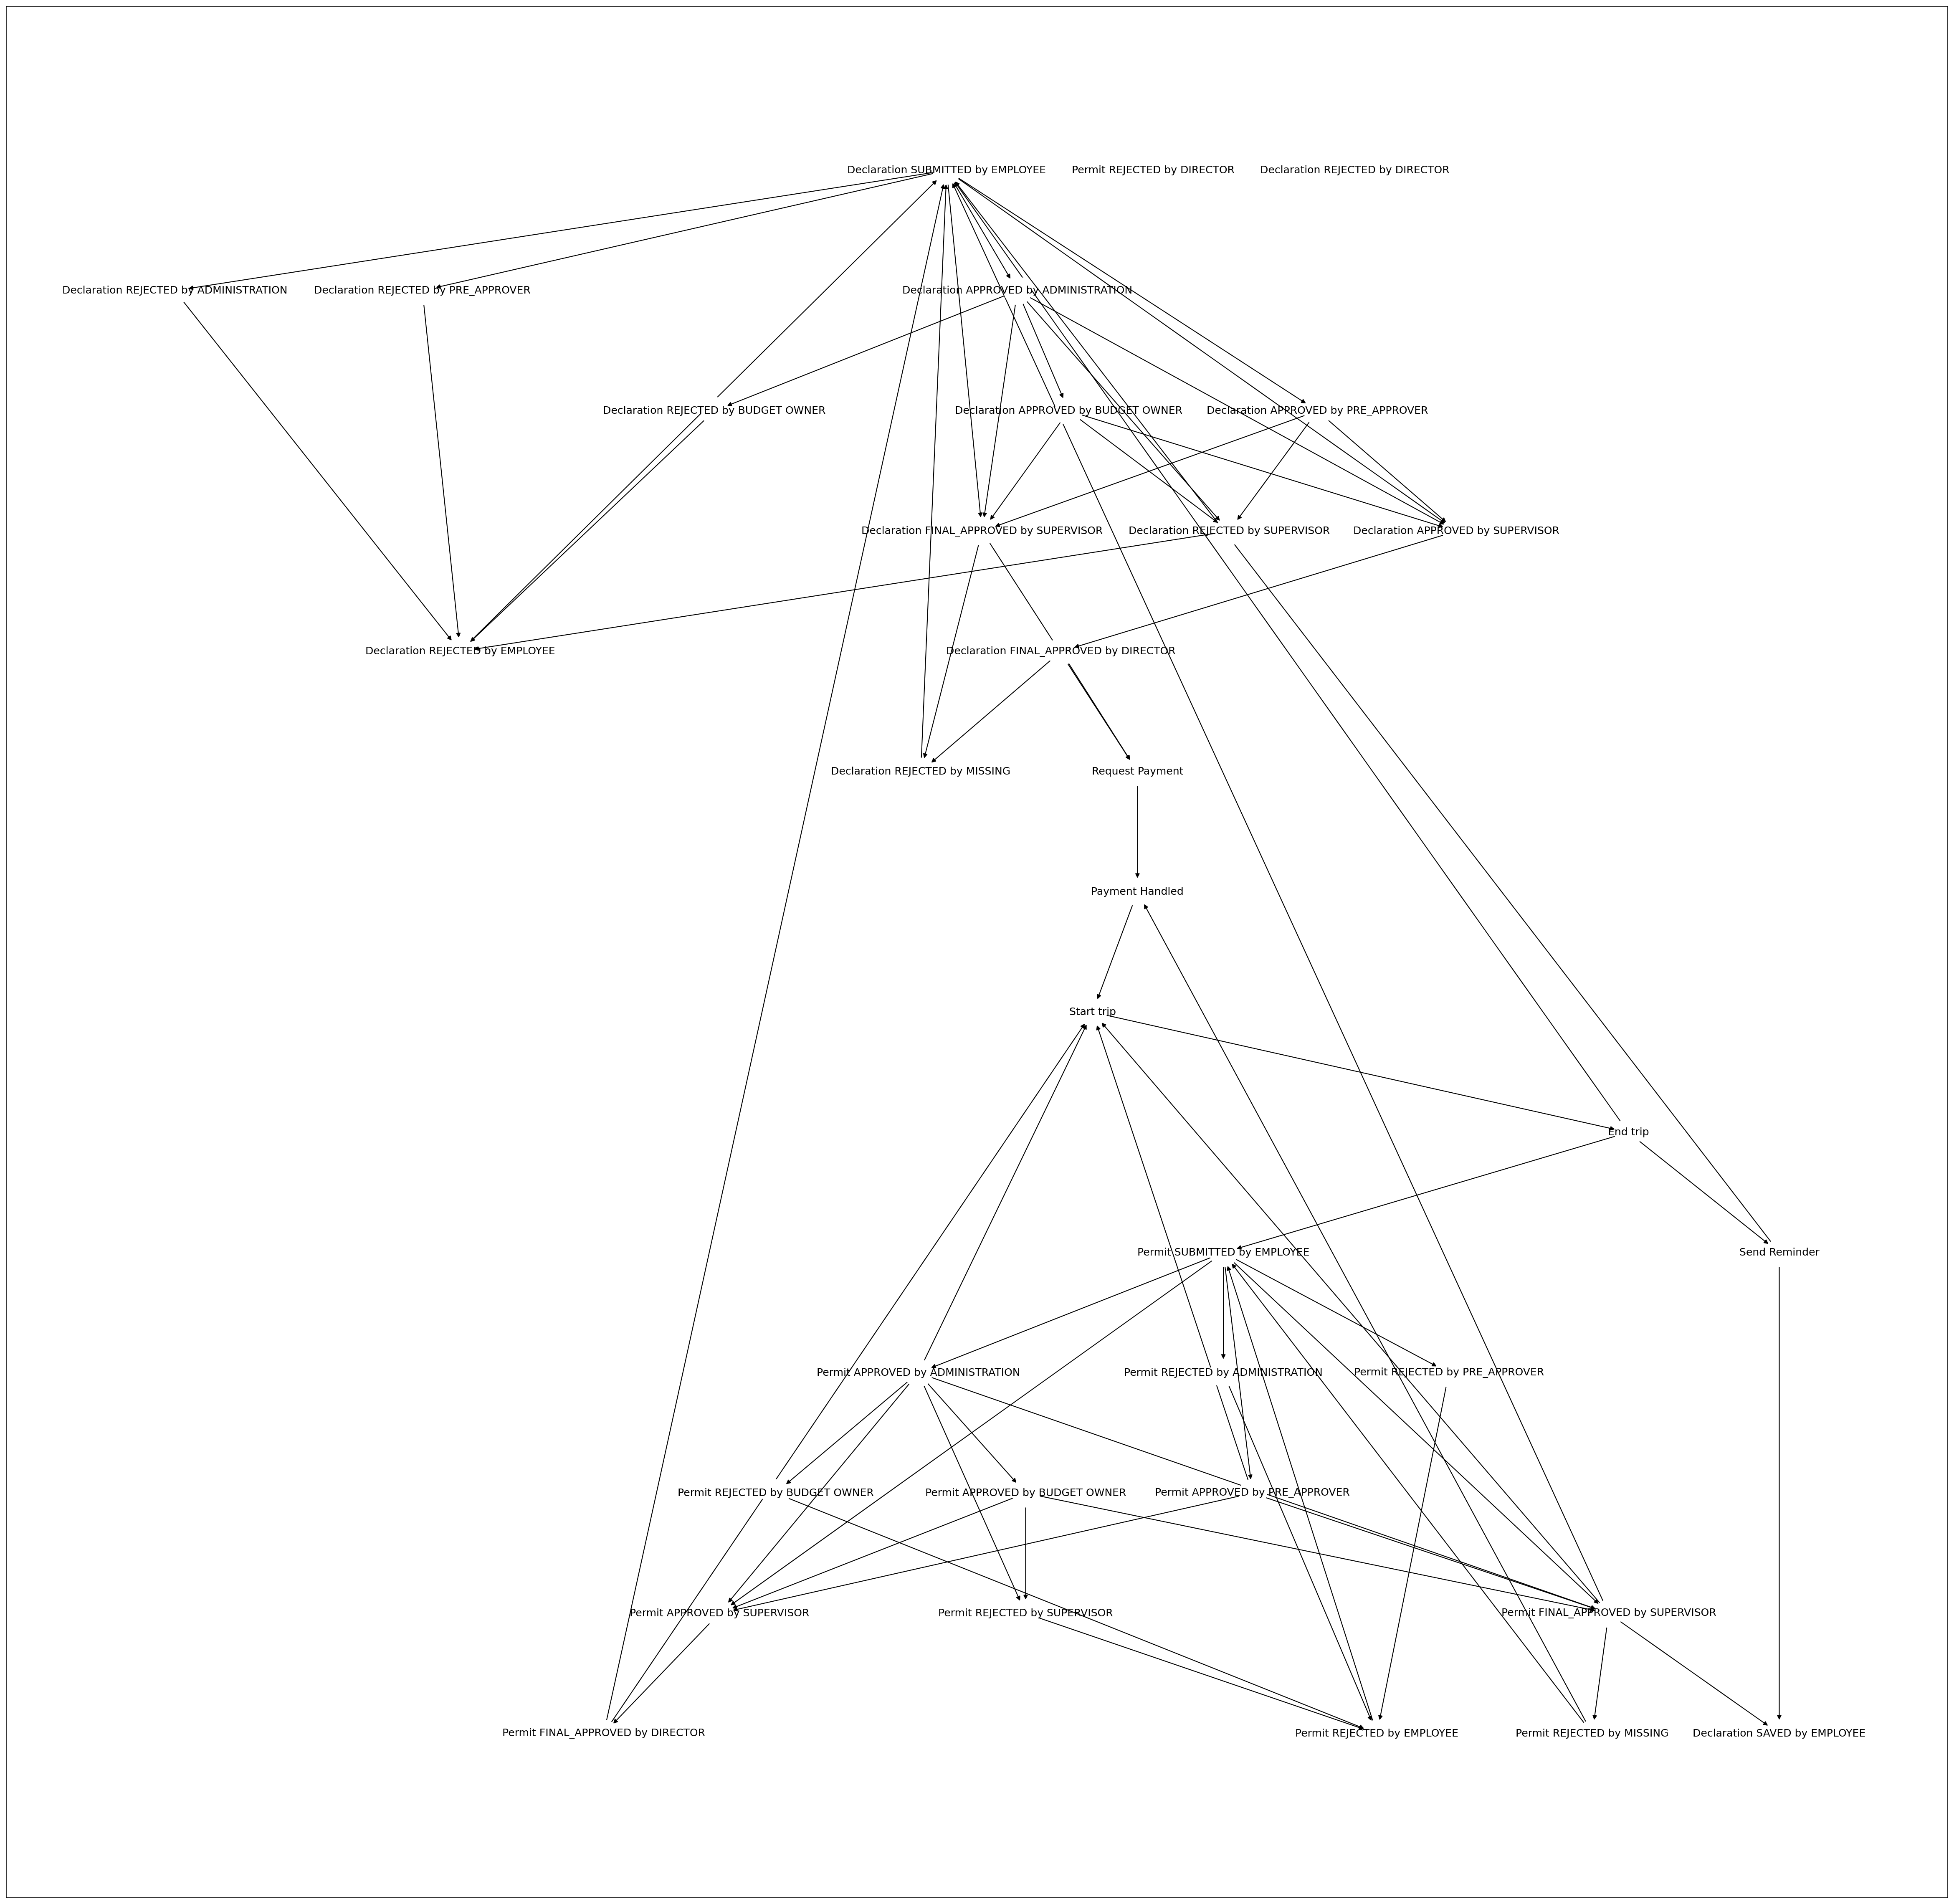

In [239]:
plt.figure(dpi = 150, figsize = (40, 40))
nx.draw_networkx(g, pos=pos, node_color = 'white', node_size=1000)

In [227]:
net = Network(width="1000px", height="1000px", directed=True, notebook=True, layout=False)

In [228]:
net.from_nx(g)

In [229]:
for idx in start_nodes:
    net.get_node(idx)['color'] = 'green'

for idx in end_nodes:
    net.get_node(idx)['color'] = 'red'


In [230]:
net.show("proc.html")